<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/ECL/ECLLimitLevel_Truncate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings

from pandas.core.common import SettingWithCopyWarning

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style
warnings.simplefilter(action = 'ignore', category = SettingWithCopyWarning) #Off warning
pd.options.display.float_format = '{:.2f}'.format #Set 2-decimal places

In [3]:
# Import data
df = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/ECL/datasets/ECLLimitData.csv',
    dtype = {
        'LimitID': str,
        'AccountID': str
    },
    parse_dates = ['AsOfDate', 'LimitMaturity', 'AccountMaturity']
)

# Show table
df.head(5)

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity
0,2022-12-31,999999999999941,611267004,TL,574225.24,167028.16,10443.93,6.58,1,2025-12-31,2024-01-31
1,2022-12-31,999999999999941,611267005,RP,574225.24,83661.58,NaN,9.06,1,2025-12-31,2025-12-31
2,2022-12-31,999999999999941,611267006,RP,574225.24,18832.65,NaN,7.34,1,2025-12-31,2025-06-30
3,2022-12-31,999999999999941,611267007,TL,574225.24,56400.00,3460.97,5.23,1,2025-12-31,2023-12-31
4,2022-12-31,999999999999941,611267008,TL,574225.24,24890.00,1346.45,5.26,1,2025-12-31,2023-08-31


In [4]:
# Calculate remaining life
df['LimitTenor'] = round((df['LimitMaturity'] - df['AsOfDate']) / np.timedelta64(1, 'M'))
df['AccountTenor'] = round((df['AccountMaturity'] - df['AsOfDate']) / np.timedelta64(1, 'M'))

# Show table
df.head(5)

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor
0,2022-12-31,999999999999941,611267004,TL,574225.24,167028.16,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00
1,2022-12-31,999999999999941,611267005,RP,574225.24,83661.58,NaN,9.06,1,2025-12-31,2025-12-31,36.00,36.00
2,2022-12-31,999999999999941,611267006,RP,574225.24,18832.65,NaN,7.34,1,2025-12-31,2025-06-30,36.00,30.00
3,2022-12-31,999999999999941,611267007,TL,574225.24,56400.00,3460.97,5.23,1,2025-12-31,2023-12-31,36.00,12.00
4,2022-12-31,999999999999941,611267008,TL,574225.24,24890.00,1346.45,5.26,1,2025-12-31,2023-08-31,36.00,8.00


In [5]:
# Define next balance function
def balances(rate, payment, os):
  interestAmount = os * rate / 100 / 12
  nextBalance = os + interestAmount - payment
  return nextBalance

In [6]:
# Define amortization function
def AMT(inputData, stage, tenor, amortization = []):
  # Get amortization parameters
  rate = inputData['EIR'].values[0]
  payment = inputData['Installment'].values[0]
  amount = inputData['Outstanding'].values[0]
  amortization = [amount] #Get outstanding at reporting date
  '''
  If outstanding less than payment, it means the reporting date is the last date.
  Therefore, the remaining outstanding will be used for ECL without amortization.
  '''
  if amount - payment <= 0:
    inputData['DiscountTime'] = 1
    return inputData
  else:
    if stage == 1 and tenor > 12:
      for _ in range(11):
        amount = balances(rate, payment, amount) #Stage 1 amortize for 12-months
        if amount <= 0:
          continue #Remove negative payment at last outstanding
        amortization.append(amount)
      # Create new payment array
      newPayment = np.repeat(
          payment,
          len(amortization)
      )
      if len(amortization) < 12:
        newPayment[-1] = amortization[-1] #Last payment has to close outstanding
    else:
      for _ in range(tenor - 1):
        amount = balances(rate, payment, amount) #Stage 1 and stage 2 amortize for remaining life
        if amount <= 0:
          continue #Remove negative payment at last outstanding
        amortization.append(amount)
      # Create new payment array
      newPayment = np.repeat(
          payment,
          len(amortization)
      )
      newPayment[-1] = amortization[-1] #Last payment has to close outstanding
    # To DataFrame
    scheduleTable = pd.DataFrame(
        np.repeat(
            inputData.values,
            len(amortization),
            axis = 0
        ),
        columns = inputData.columns
    )
    scheduleTable['Outstanding'] = amortization
    scheduleTable['Installment'] = newPayment #Assign new payment to close outstanding
    scheduleTable['DiscountTime'] = scheduleTable.index + 1
  return scheduleTable

In [7]:
# Define plot OS Function
def plotOS(data, stage):
  plt.figure(figsize = (10, 6))
  plt.plot(
      data['DiscountTime'],
      data['Outstanding'],
      color = 'green',
      label = 'Amortization'
  )
  plt.bar(
      data['DiscountTime'],
      data['Installment'],
      color = 'gray',
      width = 0.9,
      label = 'Installment'
  )
  plt.xticks(
      range(data['DiscountTime'].min(), data['DiscountTime'].max() + 1, 1)
  )
  plt.title(f'EAD of stage: {stage}')
  plt.xlabel('Month after reporting date')
  plt.ylabel('Amount')
  plt.legend(frameon = True, facecolor = 'white', loc = 1)
  return plt.show()

In [8]:
# Define plot EAD Function
def plotEAD(data, stage, CCF):
  plt.figure(figsize = (10, 6))
  plt.plot(
      data['DiscountTime'],
      data['Outstanding'],
      color = 'green',
      linestyle = '--',
      label = 'Amortization'
  )
  plt.bar(
      data['DiscountTime'],
      data['AvailableLimit'],
      color = 'gray',
      width = 0.9,
      label = 'Undrawn portion'
  )
  plt.bar(
      data['DiscountTime'],
      data['AvailableLimit'] * CCF,
      color = 'orange',
      width = 0.9,
      label = 'Drawn portion'
  )
  plt.plot(
      data['DiscountTime'],
      data['AvailableLimit'] * CCF + data['Outstanding'],
      color = 'red',
      linewidth = 3,
      label = 'EAD with drawn portion'
  )
  if len(data['DiscountTime']) > 30:
    n = 2
  else:
    n = 1
  plt.xticks(
      range(data['DiscountTime'].min(), data['DiscountTime'].max() + 1, n)
  )
  plt.title(f'EAD with avaialble limit stage {stage}')
  plt.xlabel('Month after reporting date')
  plt.ylabel('Amount')
  plt.legend(frameon = True, facecolor = 'white', loc = 1)
  return plt.show()

## Term loan example
### Case 1
Stage 1: Term loan account and not closing before 12 months.
The account has remaining tenor as 13 months hence, outstanding will be amortized only 12 months.

In [9]:
# Example
sample = df.query("AccountID == '611267004'")
sampleAMT = AMT(sample, int(sample['Stage']), int(sample['AccountTenor']))
sampleAMT

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31,999999999999941,611267004,TL,574225.24,167028.16,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00,1
1,2022-12-31,999999999999941,611267004,TL,574225.24,157500.10,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00,2
2,2022-12-31,999999999999941,611267004,TL,574225.24,147919.80,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00,3
3,2022-12-31,999999999999941,611267004,TL,574225.24,138286.96,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00,4
4,2022-12-31,999999999999941,611267004,TL,574225.24,128601.30,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00,5
5,2022-12-31,999999999999941,611267004,TL,574225.24,118862.54,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00,6
6,2022-12-31,999999999999941,611267004,TL,574225.24,109070.37,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00,7
7,2022-12-31,999999999999941,611267004,TL,574225.24,99224.51,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00,8
8,2022-12-31,999999999999941,611267004,TL,574225.24,89324.66,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00,9
9,2022-12-31,999999999999941,611267004,TL,574225.24,79370.53,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00,10


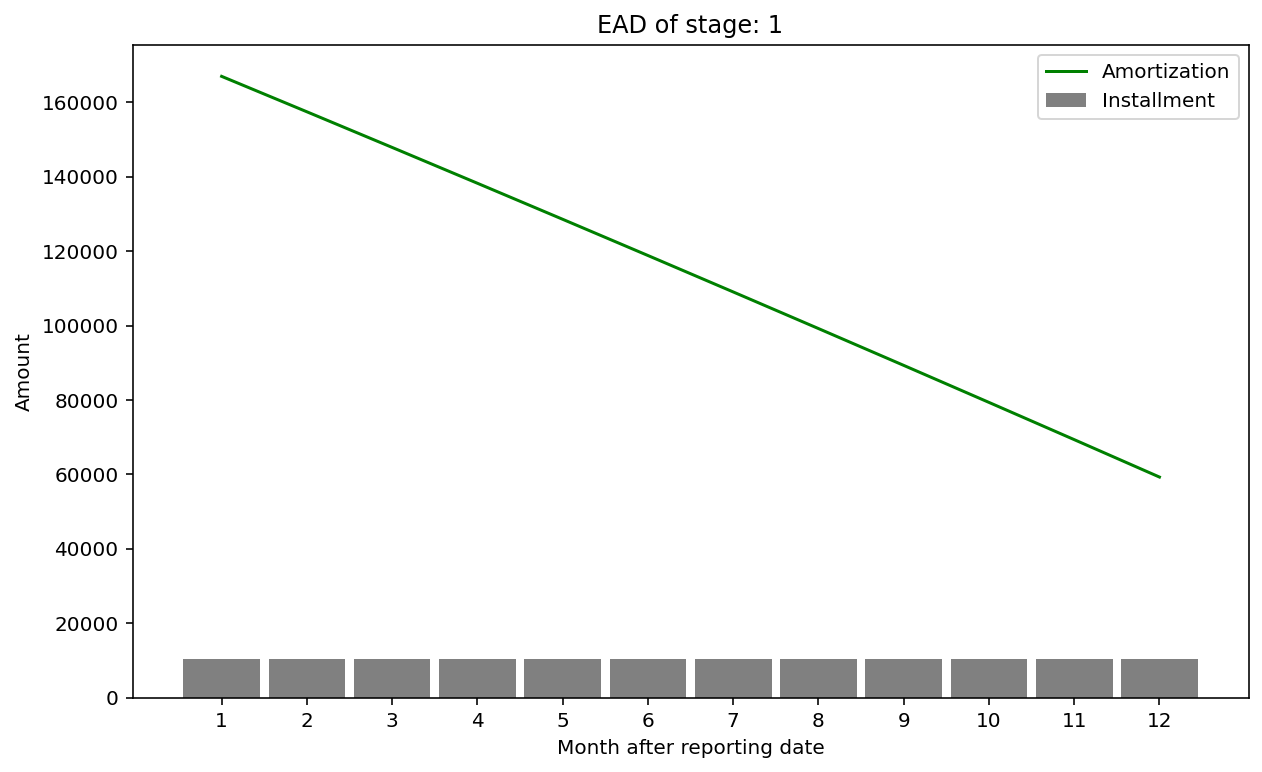

In [10]:
# Plot
plotOS(sampleAMT, 1)

### Case 2
Stage 1: Term loan account and remaining tenor less than 12 months.
The account has remaining tenor as 8 months hence, outstanding will be amortized only 8 months.
At the month 8, the installment will be full repaid for closing the loan.

In [11]:
# Example
sample = df.query("AccountID == '611267008'")
sampleAMT = AMT(sample, int(sample['Stage']), int(sample['AccountTenor']))
sampleAMT

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31,999999999999941,611267008,TL,574225.24,24890.00,1346.45,5.26,1,2025-12-31,2023-08-31,36.00,8.00,1
1,2022-12-31,999999999999941,611267008,TL,574225.24,23652.65,1346.45,5.26,1,2025-12-31,2023-08-31,36.00,8.00,2
2,2022-12-31,999999999999941,611267008,TL,574225.24,22409.88,1346.45,5.26,1,2025-12-31,2023-08-31,36.00,8.00,3
3,2022-12-31,999999999999941,611267008,TL,574225.24,21161.66,1346.45,5.26,1,2025-12-31,2023-08-31,36.00,8.00,4
4,2022-12-31,999999999999941,611267008,TL,574225.24,19907.97,1346.45,5.26,1,2025-12-31,2023-08-31,36.00,8.00,5
5,2022-12-31,999999999999941,611267008,TL,574225.24,18648.78,1346.45,5.26,1,2025-12-31,2023-08-31,36.00,8.00,6
6,2022-12-31,999999999999941,611267008,TL,574225.24,17384.07,1346.45,5.26,1,2025-12-31,2023-08-31,36.00,8.00,7
7,2022-12-31,999999999999941,611267008,TL,574225.24,16113.82,16113.82,5.26,1,2025-12-31,2023-08-31,36.00,8.00,8


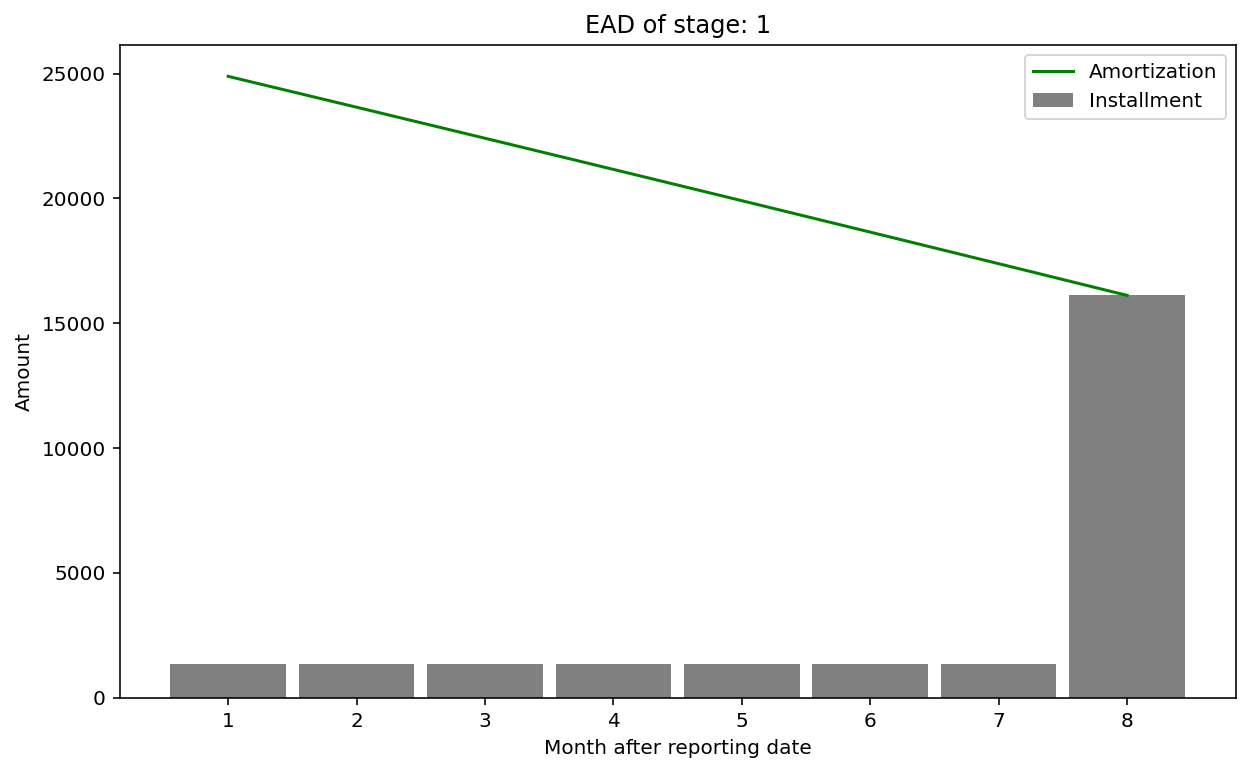

In [12]:
# Plot
plotOS(sampleAMT, 1)

### Case 3
Stage 1: Term loan account and closing before 12 months.
The account has remaining tenor as 21 months but the account is closed before.
The amortization will be calculated until closing period.

In [13]:
# Example
sample = df.query("AccountID == '541047303'")
sampleAMT = AMT(sample, int(sample['Stage']), int(sample['AccountTenor']))
sampleAMT

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31,999999999999909,541047303,TL,420934.58,26601.08,8411.21,5.23,1,2027-09-30,2024-09-30,57.00,21.00,1
1,2022-12-31,999999999999909,541047303,TL,420934.58,18305.81,8411.21,5.23,1,2027-09-30,2024-09-30,57.00,21.00,2
2,2022-12-31,999999999999909,541047303,TL,420934.58,9974.38,8411.21,5.23,1,2027-09-30,2024-09-30,57.00,21.00,3
3,2022-12-31,999999999999909,541047303,TL,420934.58,1606.64,1606.64,5.23,1,2027-09-30,2024-09-30,57.00,21.00,4


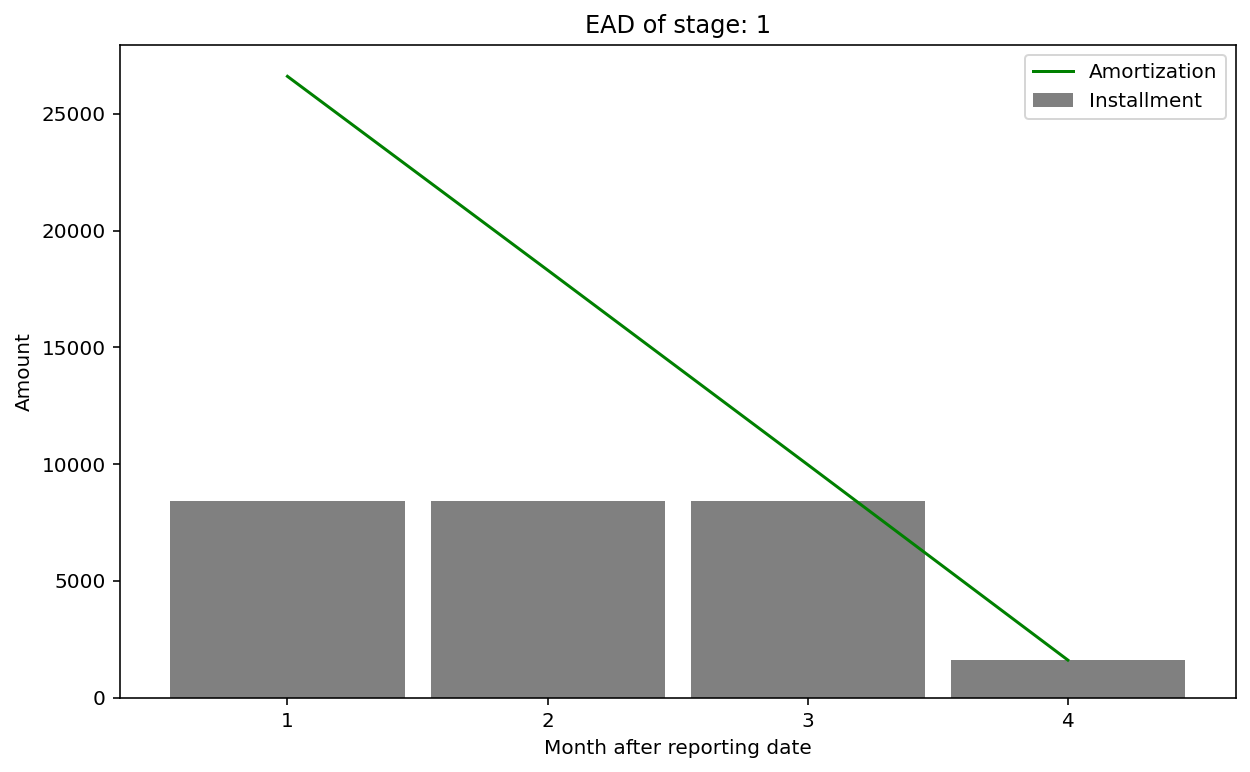

In [14]:
# Plot
plotOS(sampleAMT, 1)

### Case 4
Stage 1: Term loan account and closing at 12 months.
The account has remaining tenor equal to 12 months hence, outstanding will be amortized for 12 months.
If there is any outstanding left,  the installment will be full repaid for closing the loan.

In [15]:
# Example
sample = df.query("AccountID == '611267007'")
sampleAMT = AMT(sample, int(sample['Stage']), int(sample['AccountTenor']))
sampleAMT

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31,999999999999941,611267007,TL,574225.24,56400.00,3460.97,5.23,1,2025-12-31,2023-12-31,36.00,12.00,1
1,2022-12-31,999999999999941,611267007,TL,574225.24,53184.84,3460.97,5.23,1,2025-12-31,2023-12-31,36.00,12.00,2
2,2022-12-31,999999999999941,611267007,TL,574225.24,49955.67,3460.97,5.23,1,2025-12-31,2023-12-31,36.00,12.00,3
3,2022-12-31,999999999999941,611267007,TL,574225.24,46712.42,3460.97,5.23,1,2025-12-31,2023-12-31,36.00,12.00,4
4,2022-12-31,999999999999941,611267007,TL,574225.24,43455.04,3460.97,5.23,1,2025-12-31,2023-12-31,36.00,12.00,5
5,2022-12-31,999999999999941,611267007,TL,574225.24,40183.46,3460.97,5.23,1,2025-12-31,2023-12-31,36.00,12.00,6
6,2022-12-31,999999999999941,611267007,TL,574225.24,36897.62,3460.97,5.23,1,2025-12-31,2023-12-31,36.00,12.00,7
7,2022-12-31,999999999999941,611267007,TL,574225.24,33597.47,3460.97,5.23,1,2025-12-31,2023-12-31,36.00,12.00,8
8,2022-12-31,999999999999941,611267007,TL,574225.24,30282.92,3460.97,5.23,1,2025-12-31,2023-12-31,36.00,12.00,9
9,2022-12-31,999999999999941,611267007,TL,574225.24,26953.94,3460.97,5.23,1,2025-12-31,2023-12-31,36.00,12.00,10


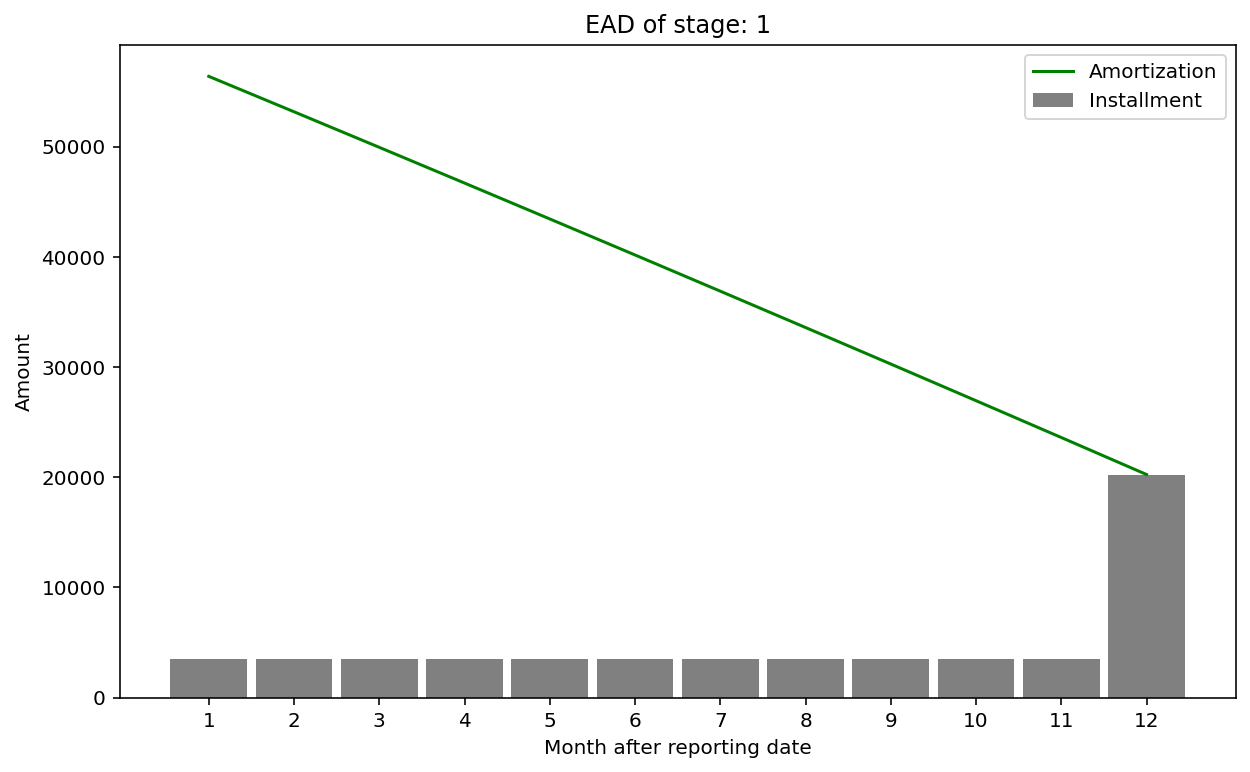

In [16]:
# Plot
plotOS(sampleAMT, 1)

### Case 5
Stage 2: Term loan account and closing before remaining tenor.
The account has remaining tenor as 43 months hence, outstanding will be amortized for 43 months.
However, if the outstanding becomes 0 before remaining tenor, outstanding will be amortized until that period.

In [17]:
# Example
sample = df.query("AccountID == '521028378'")
sampleAMT = AMT(sample, int(sample['Stage']), int(sample['AccountTenor']))
sampleAMT

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31,999999999999979,521028378,TL,743438.31,621959.86,29607.48,4.73,2,2027-06-30,2026-07-31,54.00,43.00,1
1,2022-12-31,999999999999979,521028378,TL,743438.31,594803.94,29607.48,4.73,2,2027-06-30,2026-07-31,54.00,43.00,2
2,2022-12-31,999999999999979,521028378,TL,743438.31,567540.98,29607.48,4.73,2,2027-06-30,2026-07-31,54.00,43.00,3
3,2022-12-31,999999999999979,521028378,TL,743438.31,540170.55,29607.48,4.73,2,2027-06-30,2026-07-31,54.00,43.00,4
4,2022-12-31,999999999999979,521028378,TL,743438.31,512692.25,29607.48,4.73,2,2027-06-30,2026-07-31,54.00,43.00,5
5,2022-12-31,999999999999979,521028378,TL,743438.31,485105.63,29607.48,4.73,2,2027-06-30,2026-07-31,54.00,43.00,6
6,2022-12-31,999999999999979,521028378,TL,743438.31,457410.27,29607.48,4.73,2,2027-06-30,2026-07-31,54.00,43.00,7
7,2022-12-31,999999999999979,521028378,TL,743438.31,429605.75,29607.48,4.73,2,2027-06-30,2026-07-31,54.00,43.00,8
8,2022-12-31,999999999999979,521028378,TL,743438.31,401691.64,29607.48,4.73,2,2027-06-30,2026-07-31,54.00,43.00,9
9,2022-12-31,999999999999979,521028378,TL,743438.31,373667.49,29607.48,4.73,2,2027-06-30,2026-07-31,54.00,43.00,10


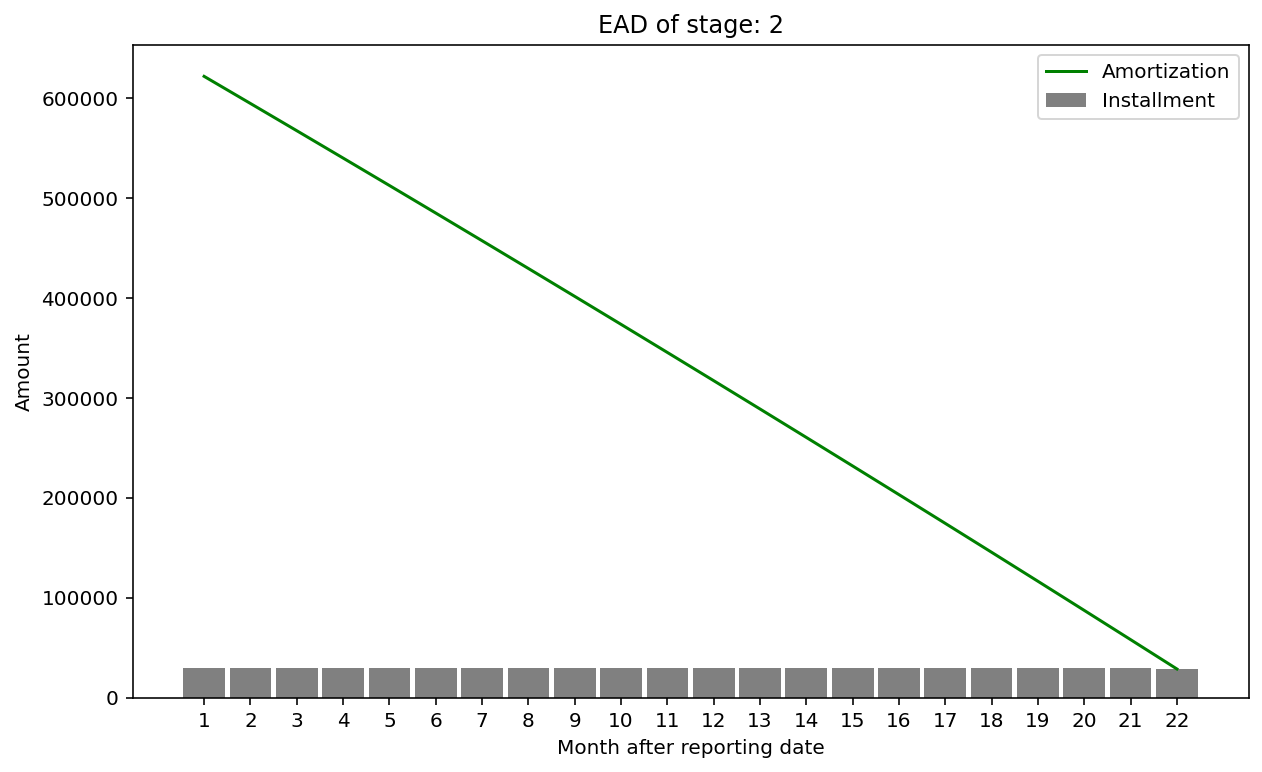

In [18]:
# Plot
plotOS(sampleAMT, 2)

### Case 6
Stage 2: Term loan account and closing before remaining tenor.
The account has remaining tenor as 48 months hence, outstanding will be amortized for 48 months.
However, if the outstanding becomes 0 before remaining tenor, outstanding will be amortized until that period.

In [19]:
# Example
sample = df.query("AccountID == '521028380'")
sampleAMT = AMT(sample, int(sample['Stage']), int(sample['AccountTenor']))
sampleAMT

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31,999999999999979,521028380,TL,743438.31,24676.52,7053.27,4.73,2,2027-06-30,2026-12-31,54.00,48.00,1
1,2022-12-31,999999999999979,521028380,TL,743438.31,17720.51,7053.27,4.73,2,2027-06-30,2026-12-31,54.00,48.00,2
2,2022-12-31,999999999999979,521028380,TL,743438.31,10737.09,7053.27,4.73,2,2027-06-30,2026-12-31,54.00,48.00,3
3,2022-12-31,999999999999979,521028380,TL,743438.31,3726.15,3726.15,4.73,2,2027-06-30,2026-12-31,54.00,48.00,4


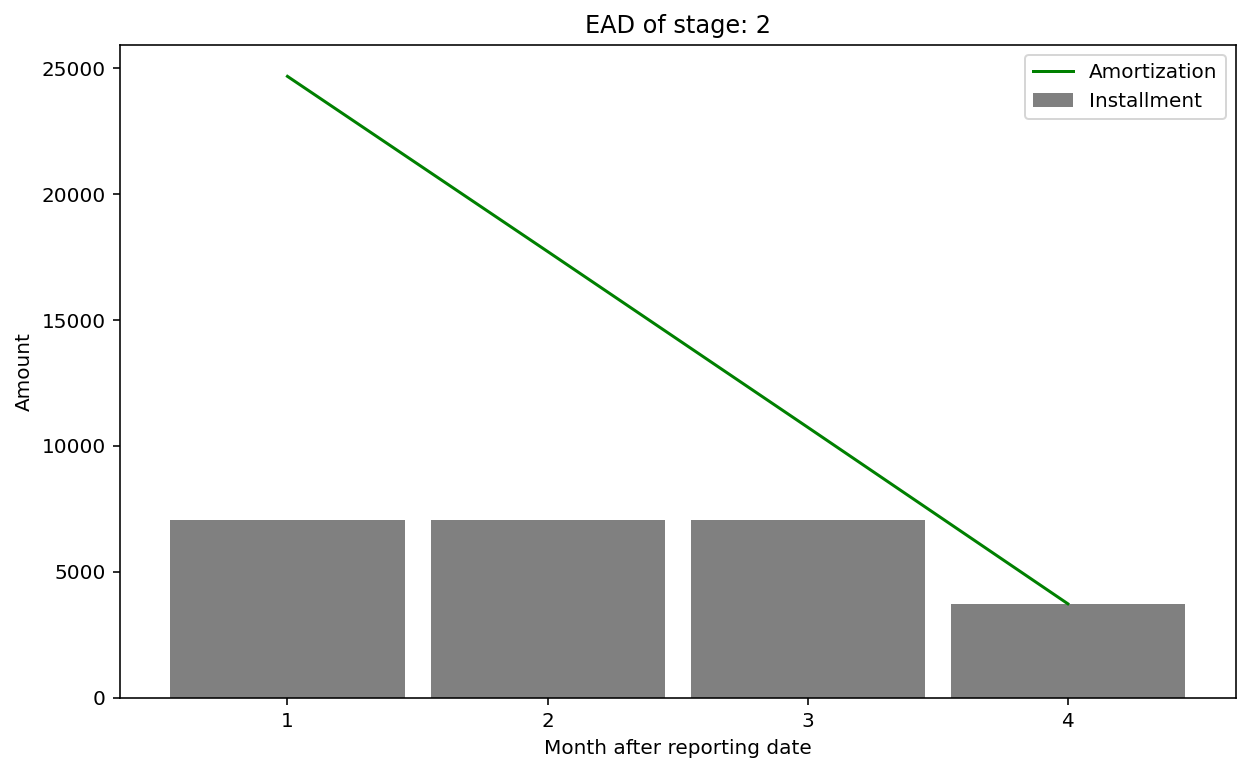

In [20]:
# Plot
plotOS(sampleAMT, 2)

## Revolving product example
The data needs to calculate minimum payment of the loan. Assume minimum payment rate at 2% of balance.

In [21]:
# Calculate minimum payment
dfSample = df.copy()
dfSample['Installment'] = np.where(
    dfSample['Installment'].isnull(),
    0.02 * dfSample['Outstanding'], #Assume 5% payment of balance
    dfSample['Installment']
)

# Show table
dfSample.head(5)

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor
0,2022-12-31,999999999999941,611267004,TL,574225.24,167028.16,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00
1,2022-12-31,999999999999941,611267005,RP,574225.24,83661.58,1673.23,9.06,1,2025-12-31,2025-12-31,36.00,36.00
2,2022-12-31,999999999999941,611267006,RP,574225.24,18832.65,376.65,7.34,1,2025-12-31,2025-06-30,36.00,30.00
3,2022-12-31,999999999999941,611267007,TL,574225.24,56400.00,3460.97,5.23,1,2025-12-31,2023-12-31,36.00,12.00
4,2022-12-31,999999999999941,611267008,TL,574225.24,24890.00,1346.45,5.26,1,2025-12-31,2023-08-31,36.00,8.00


### Case 1
Stage 1: Revolving product account and not closing before 12 months.
The account has remaining tenor as 36 months hence, outstanding will be amortized only 12 months.

In [22]:
# Example
sample = dfSample.query("AccountID == '611267005'")
sampleAMT = AMT(sample, int(sample['Stage']), int(sample['AccountTenor']))
sampleAMT

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31,999999999999941,611267005,RP,574225.24,83661.58,1673.23,9.06,1,2025-12-31,2025-12-31,36.00,36.00,1
1,2022-12-31,999999999999941,611267005,RP,574225.24,82619.99,1673.23,9.06,1,2025-12-31,2025-12-31,36.00,36.00,2
2,2022-12-31,999999999999941,611267005,RP,574225.24,81570.54,1673.23,9.06,1,2025-12-31,2025-12-31,36.00,36.00,3
3,2022-12-31,999999999999941,611267005,RP,574225.24,80513.17,1673.23,9.06,1,2025-12-31,2025-12-31,36.00,36.00,4
4,2022-12-31,999999999999941,611267005,RP,574225.24,79447.81,1673.23,9.06,1,2025-12-31,2025-12-31,36.00,36.00,5
5,2022-12-31,999999999999941,611267005,RP,574225.24,78374.41,1673.23,9.06,1,2025-12-31,2025-12-31,36.00,36.00,6
6,2022-12-31,999999999999941,611267005,RP,574225.24,77292.91,1673.23,9.06,1,2025-12-31,2025-12-31,36.00,36.00,7
7,2022-12-31,999999999999941,611267005,RP,574225.24,76203.24,1673.23,9.06,1,2025-12-31,2025-12-31,36.00,36.00,8
8,2022-12-31,999999999999941,611267005,RP,574225.24,75105.34,1673.23,9.06,1,2025-12-31,2025-12-31,36.00,36.00,9
9,2022-12-31,999999999999941,611267005,RP,574225.24,73999.15,1673.23,9.06,1,2025-12-31,2025-12-31,36.00,36.00,10


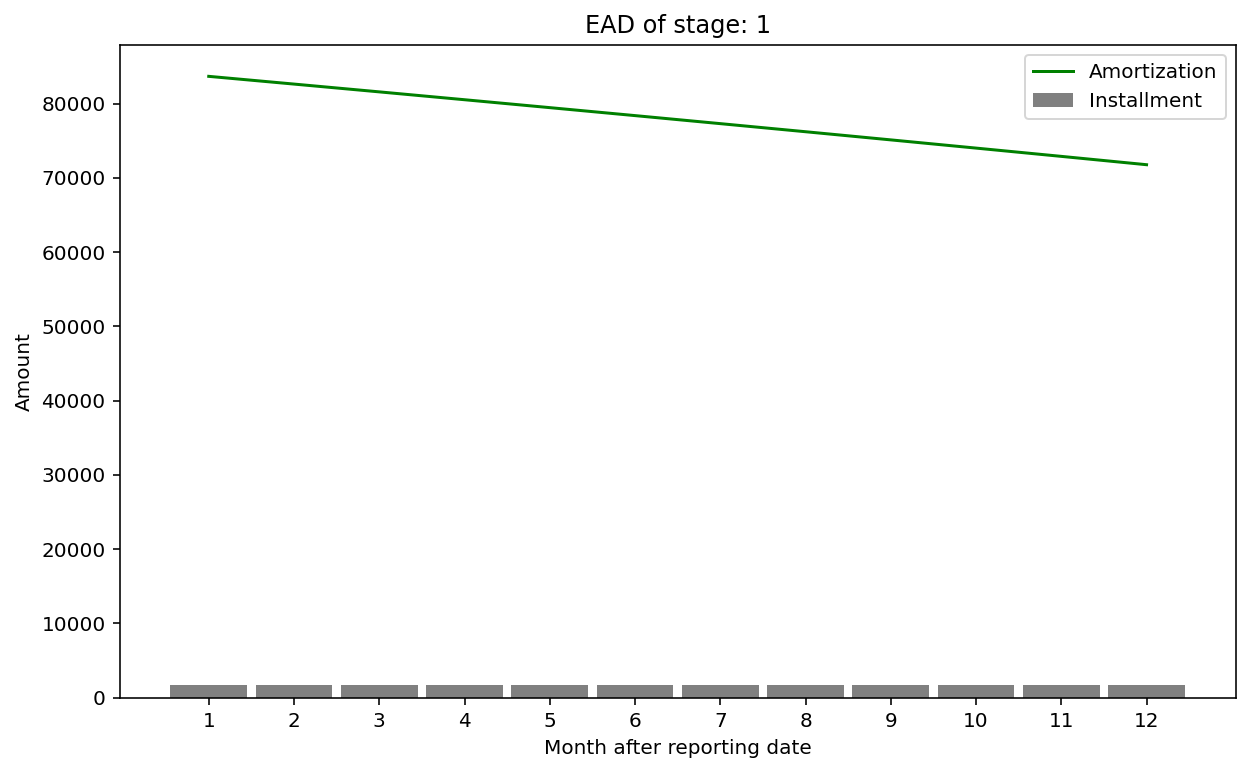

In [23]:
# Plot
plotOS(sampleAMT, 1)

### Case 2
Stage 2: Revolving product account and closing at remaining tenor. The account has remaining tenor as 3 months hence, outstanding will be amortized for 3 months. The amortization will be calculated until remaining tenor period. If there is any outstanding left, the installment will be full repaid for closing the loan.

In [24]:
# Example
sample = dfSample.query("AccountID == '541056178'")
sampleAMT = AMT(sample, int(sample['Stage']), int(sample['AccountTenor']))
sampleAMT

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31,999999999999934,541056178,RP,800023.37,221799.09,4435.98,10.66,2,2026-03-31,2023-03-31,39.00,3.00,1
1,2022-12-31,999999999999934,541056178,RP,800023.37,219333.42,4435.98,10.66,2,2026-03-31,2023-03-31,39.00,3.00,2
2,2022-12-31,999999999999934,541056178,RP,800023.37,216845.85,216845.85,10.66,2,2026-03-31,2023-03-31,39.00,3.00,3


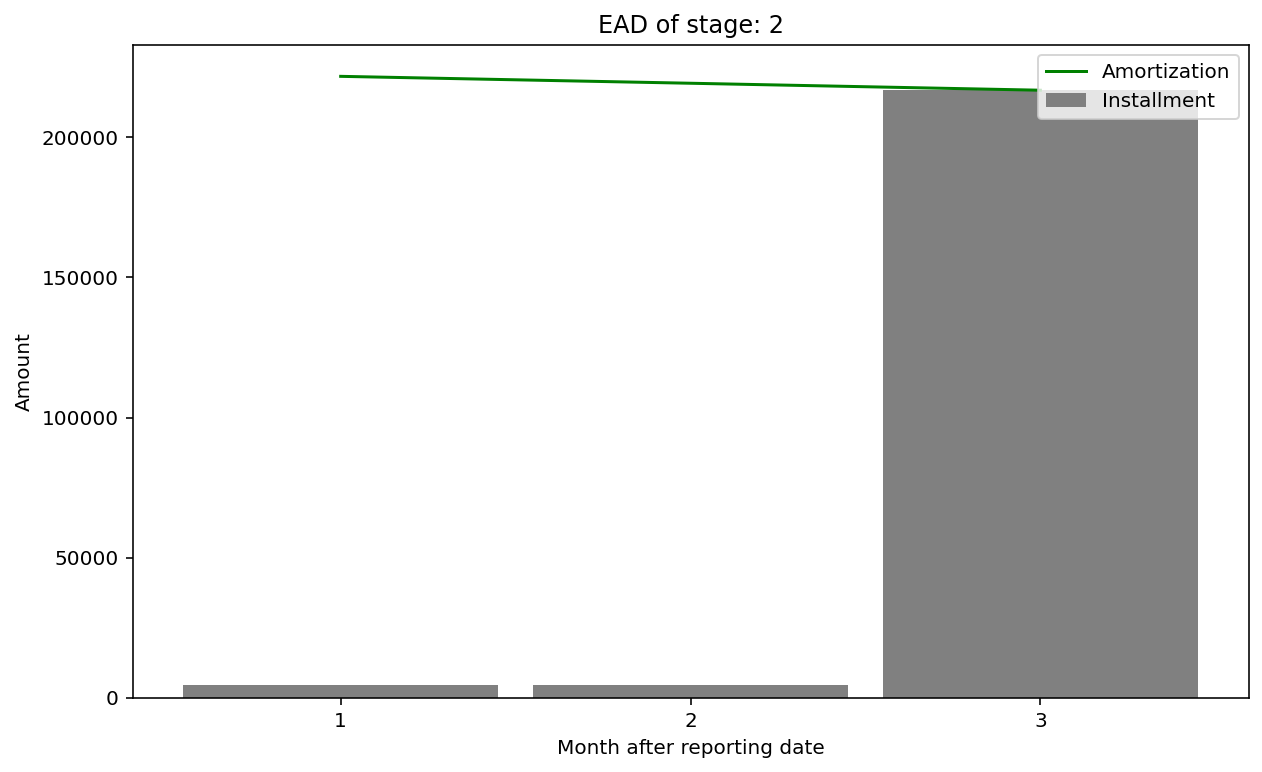

In [25]:
# Plot
plotOS(sampleAMT, 2)

### Case 3
Stage 2: Revolving product account and closing at remaining tenor. The account has remaining tenor as 39 months hence, outstanding will be amortized for 39 months. The amortization will be calculated until remaining tenor period. If there is any outstanding left, the installment will be full repaid for closing the loan.

In [26]:
# Example
sample = dfSample.query("AccountID == '541056180'")
sampleAMT = AMT(sample, int(sample['Stage']), int(sample['AccountTenor']))
sampleAMT

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31,999999999999934,541056180,RP,800023.37,89552.30,1791.05,6.65,2,2026-03-31,2026-03-31,39.00,39.00,1
1,2022-12-31,999999999999934,541056180,RP,800023.37,88257.52,1791.05,6.65,2,2026-03-31,2026-03-31,39.00,39.00,2
2,2022-12-31,999999999999934,541056180,RP,800023.37,86955.57,1791.05,6.65,2,2026-03-31,2026-03-31,39.00,39.00,3
3,2022-12-31,999999999999934,541056180,RP,800023.37,85646.40,1791.05,6.65,2,2026-03-31,2026-03-31,39.00,39.00,4
4,2022-12-31,999999999999934,541056180,RP,800023.37,84329.98,1791.05,6.65,2,2026-03-31,2026-03-31,39.00,39.00,5
5,2022-12-31,999999999999934,541056180,RP,800023.37,83006.26,1791.05,6.65,2,2026-03-31,2026-03-31,39.00,39.00,6
6,2022-12-31,999999999999934,541056180,RP,800023.37,81675.21,1791.05,6.65,2,2026-03-31,2026-03-31,39.00,39.00,7
7,2022-12-31,999999999999934,541056180,RP,800023.37,80336.78,1791.05,6.65,2,2026-03-31,2026-03-31,39.00,39.00,8
8,2022-12-31,999999999999934,541056180,RP,800023.37,78990.94,1791.05,6.65,2,2026-03-31,2026-03-31,39.00,39.00,9
9,2022-12-31,999999999999934,541056180,RP,800023.37,77637.63,1791.05,6.65,2,2026-03-31,2026-03-31,39.00,39.00,10


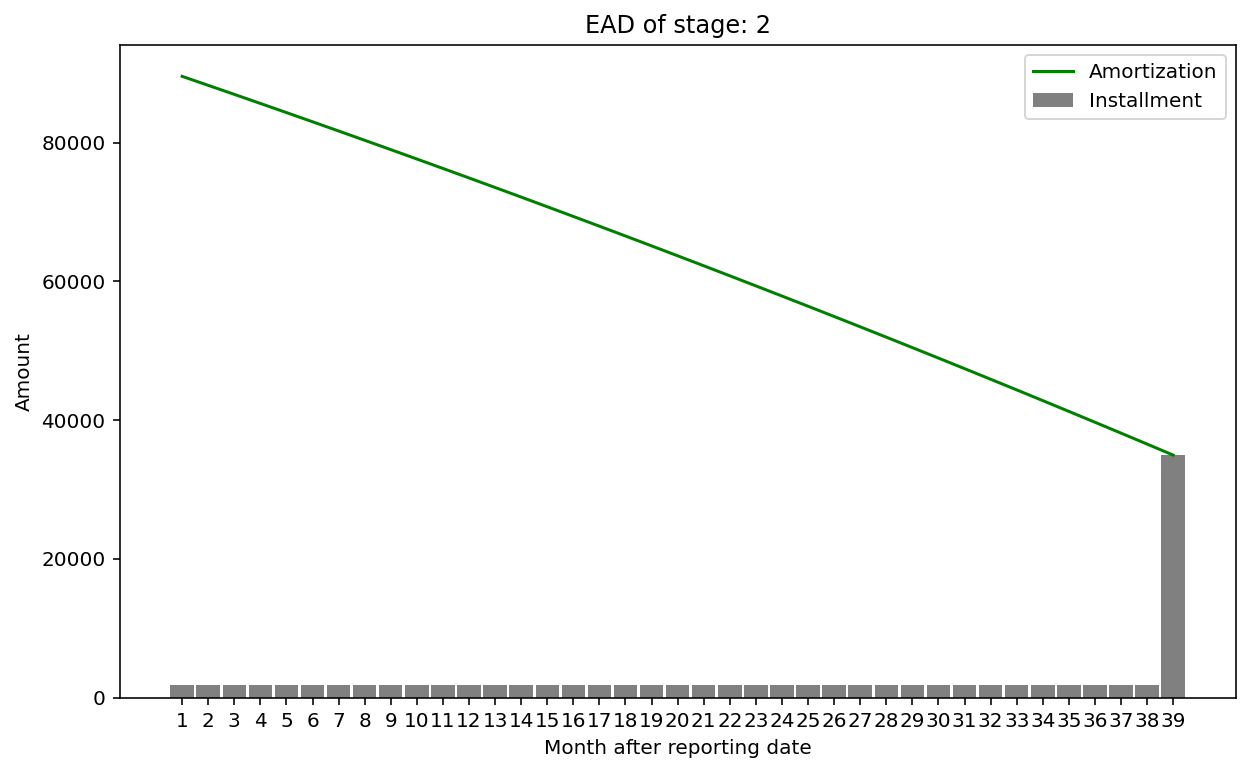

In [27]:
# Plot
plotOS(sampleAMT, 2)

Assume minimum payment rate at 5% of balance for another case study.




In [28]:
# Calculate minimum payment
dfSample = df.copy()
dfSample['Installment'] = np.where(
    dfSample['Installment'].isnull(),
    0.05 * dfSample['Outstanding'], #Assume 5% payment of balance
    dfSample['Installment']
)

# Show table
dfSample.head(5)

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor
0,2022-12-31,999999999999941,611267004,TL,574225.24,167028.16,10443.93,6.58,1,2025-12-31,2024-01-31,36.00,13.00
1,2022-12-31,999999999999941,611267005,RP,574225.24,83661.58,4183.08,9.06,1,2025-12-31,2025-12-31,36.00,36.00
2,2022-12-31,999999999999941,611267006,RP,574225.24,18832.65,941.63,7.34,1,2025-12-31,2025-06-30,36.00,30.00
3,2022-12-31,999999999999941,611267007,TL,574225.24,56400.00,3460.97,5.23,1,2025-12-31,2023-12-31,36.00,12.00
4,2022-12-31,999999999999941,611267008,TL,574225.24,24890.00,1346.45,5.26,1,2025-12-31,2023-08-31,36.00,8.00


### Case 4

Stage 2: Revolving product account and before remaining tenor. The account has remaining tenor as 39 months hence, outstanding will be amortized for 39 months. The amortization will be calculated until remaining tenor period. However, if the outstanding becomes 0 before remaining tenor, outstanding will be amortized until that period.

In [29]:
# Example
sample = dfSample.query("AccountID == '541056180'")
sampleAMT = AMT(sample, int(sample['Stage']), int(sample['AccountTenor']))
sampleAMT

,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,LimitTenor,AccountTenor,DiscountTime
0,2022-12-31,999999999999934,541056180,RP,800023.37,89552.30,4477.62,6.65,2,2026-03-31,2026-03-31,39.00,39.00,1
1,2022-12-31,999999999999934,541056180,RP,800023.37,85570.95,4477.62,6.65,2,2026-03-31,2026-03-31,39.00,39.00,2
2,2022-12-31,999999999999934,541056180,RP,800023.37,81567.54,4477.62,6.65,2,2026-03-31,2026-03-31,39.00,39.00,3
3,2022-12-31,999999999999934,541056180,RP,800023.37,77541.95,4477.62,6.65,2,2026-03-31,2026-03-31,39.00,39.00,4
4,2022-12-31,999999999999934,541056180,RP,800023.37,73494.05,4477.62,6.65,2,2026-03-31,2026-03-31,39.00,39.00,5
5,2022-12-31,999999999999934,541056180,RP,800023.37,69423.71,4477.62,6.65,2,2026-03-31,2026-03-31,39.00,39.00,6
6,2022-12-31,999999999999934,541056180,RP,800023.37,65330.82,4477.62,6.65,2,2026-03-31,2026-03-31,39.00,39.00,7
7,2022-12-31,999999999999934,541056180,RP,800023.37,61215.25,4477.62,6.65,2,2026-03-31,2026-03-31,39.00,39.00,8
8,2022-12-31,999999999999934,541056180,RP,800023.37,57076.87,4477.62,6.65,2,2026-03-31,2026-03-31,39.00,39.00,9
9,2022-12-31,999999999999934,541056180,RP,800023.37,52915.55,4477.62,6.65,2,2026-03-31,2026-03-31,39.00,39.00,10


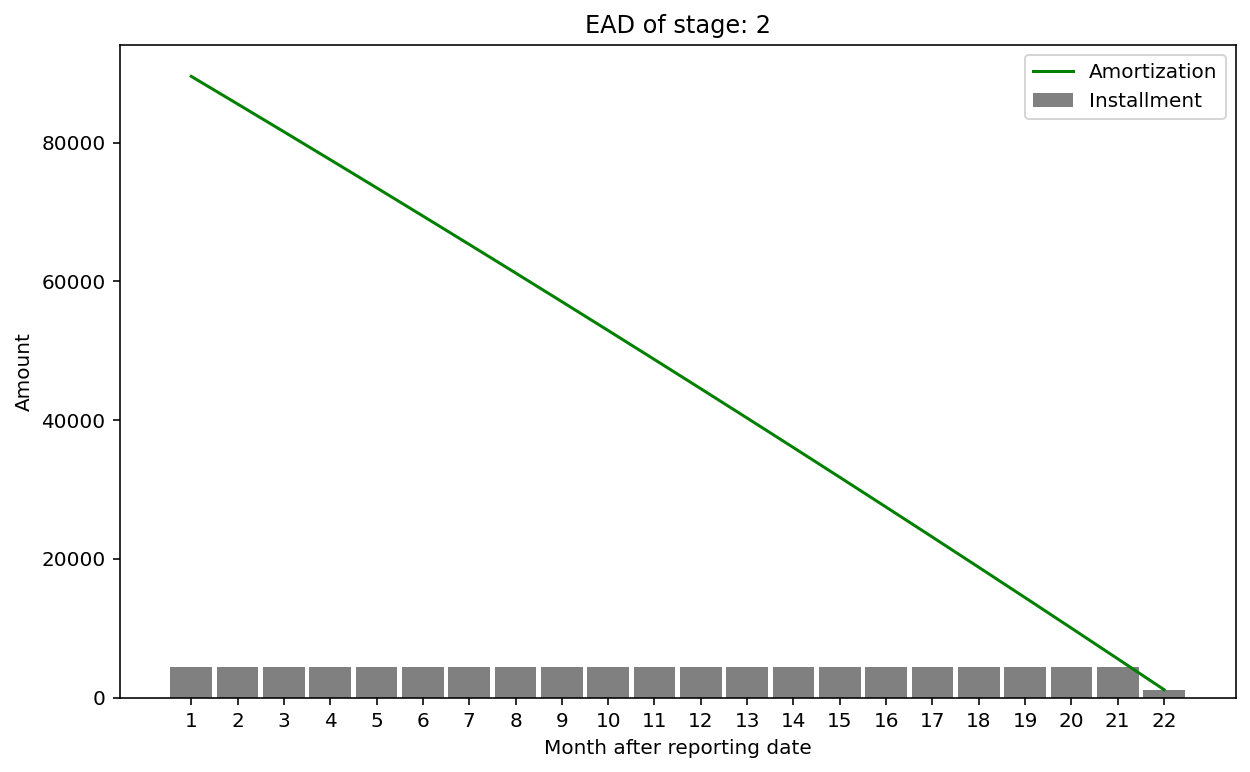

In [30]:
# Plot
plotOS(sampleAMT, 2)

In [31]:
# Amortization schedule
ECL = []

for limit in df['LimitID'].unique():
  # Get loan data
  loanData = df.query(
      "LimitID == @limit"
  )
  stage = loanData['Stage'].max() #Limit stage
  limitAvailiable = loanData['Limit'].max() - loanData['Outstanding'].sum() #Available limit amount

  # ECL for stage 3
  if stage == 3:
    scheduleLimit = loanData.groupby(
      ['AsOfDate', 'LimitID', 'Limit', 'Stage'],
      as_index = False
    ).agg(
        {
          'Outstanding': lambda amount: amount.sum(),
          'Installment': lambda amount: amount.sum()
        }
    )
    scheduleLimit['EIR'] = np.average(
        loanData['EIR'],
        weights = loanData['Outstanding']
    ) #Assign weighted EIR
    scheduleLimit['DiscountTime'] = 1
    scheduleLimit['AvailableLimit'] = limitAvailiable #Available limit at limit level
    ECL.append(scheduleLimit)
    continue

  # Separate by loan type
  # Term loan
  schedule = []
  if 'TL' in loanData['LoanType'].unique():
    termLoan = loanData.query(
        "LoanType == 'TL'"
    )
    accountSchedule = []
    for account in termLoan['AccountID'].unique():
      # Get loan data on each account ID
      data = termLoan.query(
          "AccountID == @account"
      )
      tenor = data['AccountTenor'].values[0] #Account tenor
      scheduleTable = AMT(data, int(stage), int(tenor)) #Amortization
      accountSchedule.append(scheduleTable)
    accountSchedule = pd.concat(
        accountSchedule,
        axis = 0,
        ignore_index = True
    )
    # Aggregate term loan to limit level
    accountSchedule = accountSchedule.groupby(
        ['AsOfDate', 'LimitID', 'LoanType', 'Limit', 'Stage', 'DiscountTime'],
        as_index = False
    ).agg(
        {
            'Outstanding': lambda amount: amount.sum(),
            'Installment': lambda amount: amount.sum()
        }
    )
    accountSchedule['EIR'] = np.average(
        termLoan['EIR'],
        weights = termLoan['Outstanding']
    ) #Assign weighted EIR
    schedule.append(accountSchedule)

  # Revolving product
  if 'RP' in loanData['LoanType'].unique():
    revolvingProduct = loanData.query(
        "LoanType == 'RP'"
    )
    revolvingProduct['Installment'] = 0.025 * revolvingProduct['Outstanding'] #Minimum payment
    accountSchedule = []
    for account in revolvingProduct['AccountID'].unique():
      # Get loan data on each account ID
      data = revolvingProduct.query(
          "AccountID == @account"
      )
      tenor = data['AccountTenor'].values[0] #Account tenor
      scheduleTable = AMT(data, int(stage), int(tenor)) #Amortization
      accountSchedule.append(scheduleTable)
    accountSchedule = pd.concat(
        accountSchedule,
        axis = 0,
        ignore_index = True
    )
    # Aggregate revolving product to limit level
    accountSchedule = accountSchedule.groupby(
        ['AsOfDate', 'LimitID', 'LoanType', 'Limit', 'Stage', 'DiscountTime'],
        as_index = False
    ).agg(
        {
            'Outstanding': lambda amount: amount.sum(),
            'Installment': lambda amount: amount.sum()
        }
    )
    accountSchedule['EIR'] = np.average(
        revolvingProduct['EIR'],
        weights = revolvingProduct['Outstanding']
    ) #Assign weighted EIR
    schedule.append(accountSchedule)
  
  # Combine at product level
  scheduleProduct = pd.concat(
      schedule,
      axis = 0,
      ignore_index = True
  )

  # Aggregate to limit level
  scheduleLimit = scheduleProduct.groupby(
      ['AsOfDate', 'LimitID', 'Limit', 'Stage', 'DiscountTime'],
      as_index = False
  ).agg(
      {
          'Outstanding': lambda amount: amount.sum(),
          'Installment': lambda amount: amount.sum()
      }
  )
  scheduleLimit['EIR'] = np.average(
      scheduleProduct[scheduleProduct['DiscountTime'] == 1]['EIR'].values,
      weights = scheduleProduct[scheduleProduct['DiscountTime'] == 1]['Outstanding'].values
  ) #Assign weighted EIR
  # Available limit at limit level
  scheduleLimit['AvailableLimit'] = limitAvailiable + scheduleLimit['Installment'].cumsum().shift().fillna(0)
  scheduleLimit['AvailableLimit'] = scheduleLimit[['Limit', 'AvailableLimit']].min(axis = 1) #Capped miximum at limit amount
  
  # Append result
  ECL.append(scheduleLimit)

# To DataFrame
ECL = pd.concat(
    ECL,
    axis = 0,
    ignore_index = True
)

# Show table
ECL.head(5)

,AsOfDate,LimitID,Limit,Stage,DiscountTime,Outstanding,Installment,EIR,AvailableLimit
0,2022-12-31,999999999999941,574225.24,1,1,350812.39,17813.71,6.90,223412.85
1,2022-12-31,999999999999941,574225.24,1,2,335016.30,17813.71,6.90,241226.56
2,2022-12-31,999999999999941,574225.24,1,3,319135.34,17813.71,6.90,259040.26
3,2022-12-31,999999999999941,574225.24,1,4,303169.03,17813.71,6.90,276853.97
4,2022-12-31,999999999999941,574225.24,1,5,287116.90,17813.71,6.90,294667.67


In [32]:
# Show result
# Stage 1
dataPlot = ECL.query("LimitID == '999999999999941'")
dataPlot

,AsOfDate,LimitID,Limit,Stage,DiscountTime,Outstanding,Installment,EIR,AvailableLimit
0,2022-12-31,999999999999941,574225.24,1,1,350812.39,17813.71,6.90,223412.85
1,2022-12-31,999999999999941,574225.24,1,2,335016.30,17813.71,6.90,241226.56
2,2022-12-31,999999999999941,574225.24,1,3,319135.34,17813.71,6.90,259040.26
3,2022-12-31,999999999999941,574225.24,1,4,303169.03,17813.71,6.90,276853.97
4,2022-12-31,999999999999941,574225.24,1,5,287116.90,17813.71,6.90,294667.67
5,2022-12-31,999999999999941,574225.24,1,6,270978.48,17813.71,6.90,312481.38
6,2022-12-31,999999999999941,574225.24,1,7,254753.29,17813.71,6.90,330295.08
7,2022-12-31,999999999999941,574225.24,1,8,238440.86,32581.08,6.90,348108.79
8,2022-12-31,999999999999941,574225.24,1,9,207202.69,16467.26,6.90,380689.87
9,2022-12-31,999999999999941,574225.24,1,10,191995.73,16467.26,6.90,397157.13


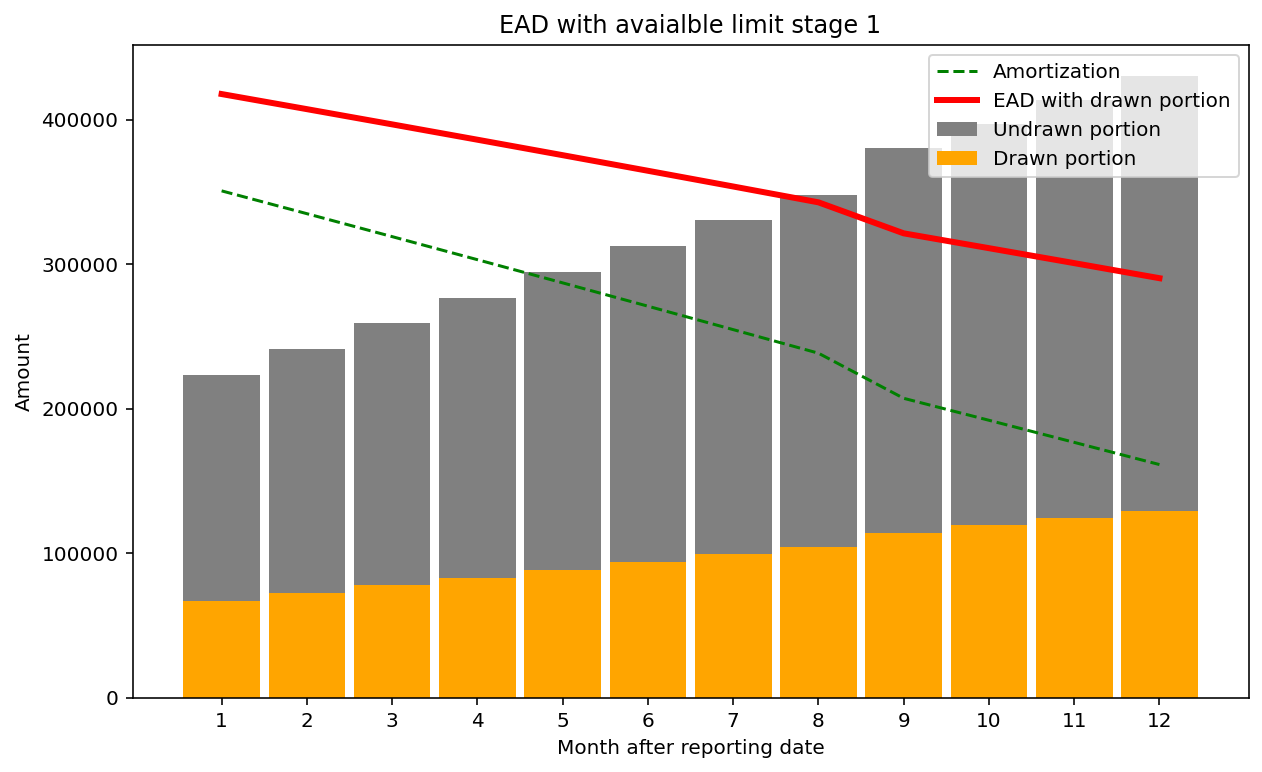

In [33]:
# Plot
plotEAD(dataPlot, 1, 0.3)

In [34]:
# Stage 2
dataPlot = ECL.query("LimitID == '999999999999979'")
dataPlot

,AsOfDate,LimitID,Limit,Stage,DiscountTime,Outstanding,Installment,EIR,AvailableLimit
13,2022-12-31,999999999999979,743438.31,2,1,743438.31,42670.78,5.32,0.00
14,2022-12-31,999999999999979,743438.31,2,2,704062.82,42670.78,5.32,42670.78
15,2022-12-31,999999999999979,743438.31,2,3,664523.80,42670.78,5.32,85341.57
16,2022-12-31,999999999999979,743438.31,2,4,624820.54,37080.70,5.32,128012.35
17,2022-12-31,999999999999979,743438.31,2,5,590520.16,31695.08,5.32,165093.05
18,2022-12-31,999999999999979,743438.31,2,6,561485.33,31695.08,5.32,196788.13
19,2022-12-31,999999999999979,743438.31,2,7,532329.90,31695.08,5.32,228483.21
20,2022-12-31,999999999999979,743438.31,2,8,503053.35,31695.08,5.32,260178.29
21,2022-12-31,999999999999979,743438.31,2,9,473655.15,31695.08,5.32,291873.38
22,2022-12-31,999999999999979,743438.31,2,10,444134.77,31695.08,5.32,323568.46


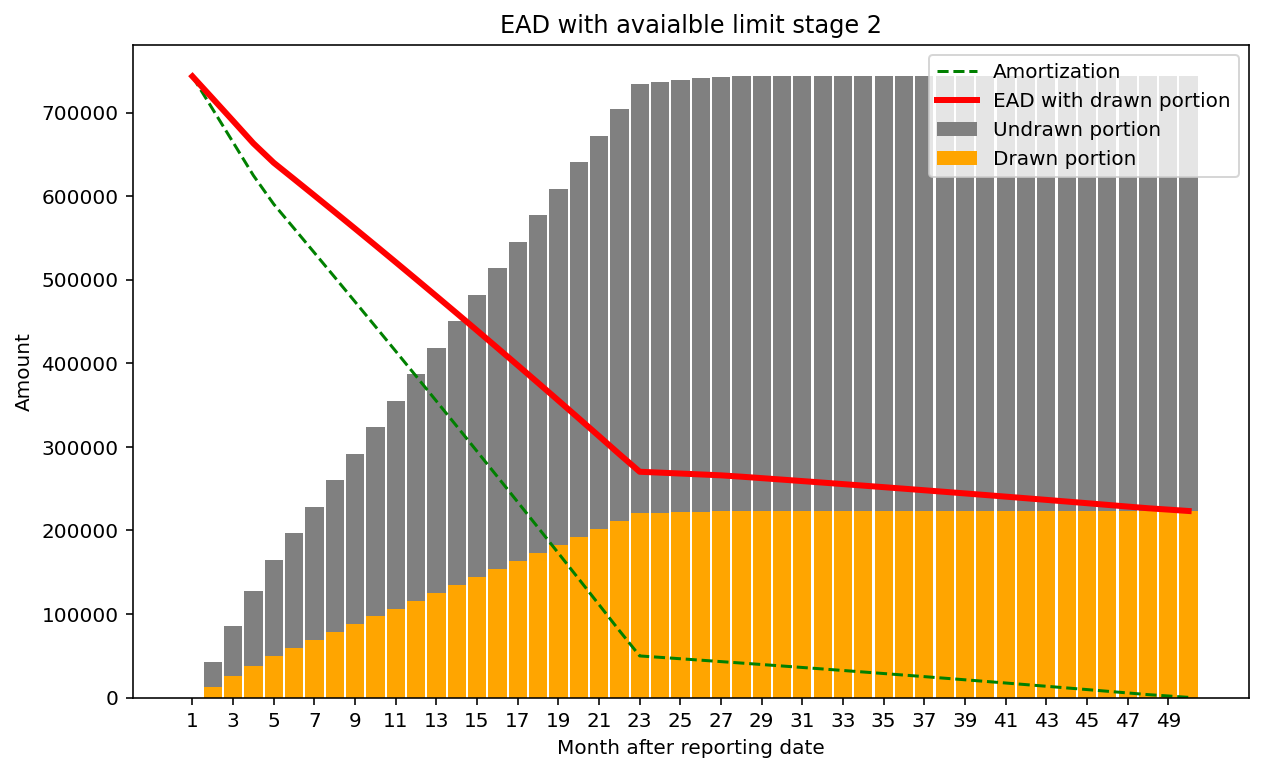

In [35]:
# Plot
plotEAD(dataPlot, 2, 0.3)

In [36]:
# Stage 2
dataPlot = ECL.query("LimitID == '999999999999934'")
dataPlot

,AsOfDate,LimitID,Limit,Stage,DiscountTime,Outstanding,Installment,EIR,AvailableLimit
63,2022-12-31,999999999999934,800023.37,2,1,716038.13,17900.95,8.49,83985.24
64,2022-12-31,999999999999934,800023.37,2,2,703200.54,17900.95,8.49,101886.19
65,2022-12-31,999999999999934,800023.37,2,3,690273.53,226973.99,8.49,119787.15
66,2022-12-31,999999999999934,800023.37,2,4,466276.90,12355.98,8.49,346761.13
67,2022-12-31,999999999999934,800023.37,2,5,456839.88,12355.98,8.49,359117.11
68,2022-12-31,999999999999934,800023.37,2,6,447344.09,12355.98,8.49,371473.09
69,2022-12-31,999999999999934,800023.37,2,7,437789.16,12355.98,8.49,383829.06
70,2022-12-31,999999999999934,800023.37,2,8,428174.71,12355.98,8.49,396185.04
71,2022-12-31,999999999999934,800023.37,2,9,418500.38,12355.98,8.49,408541.01
72,2022-12-31,999999999999934,800023.37,2,10,408765.78,12355.98,8.49,420896.99


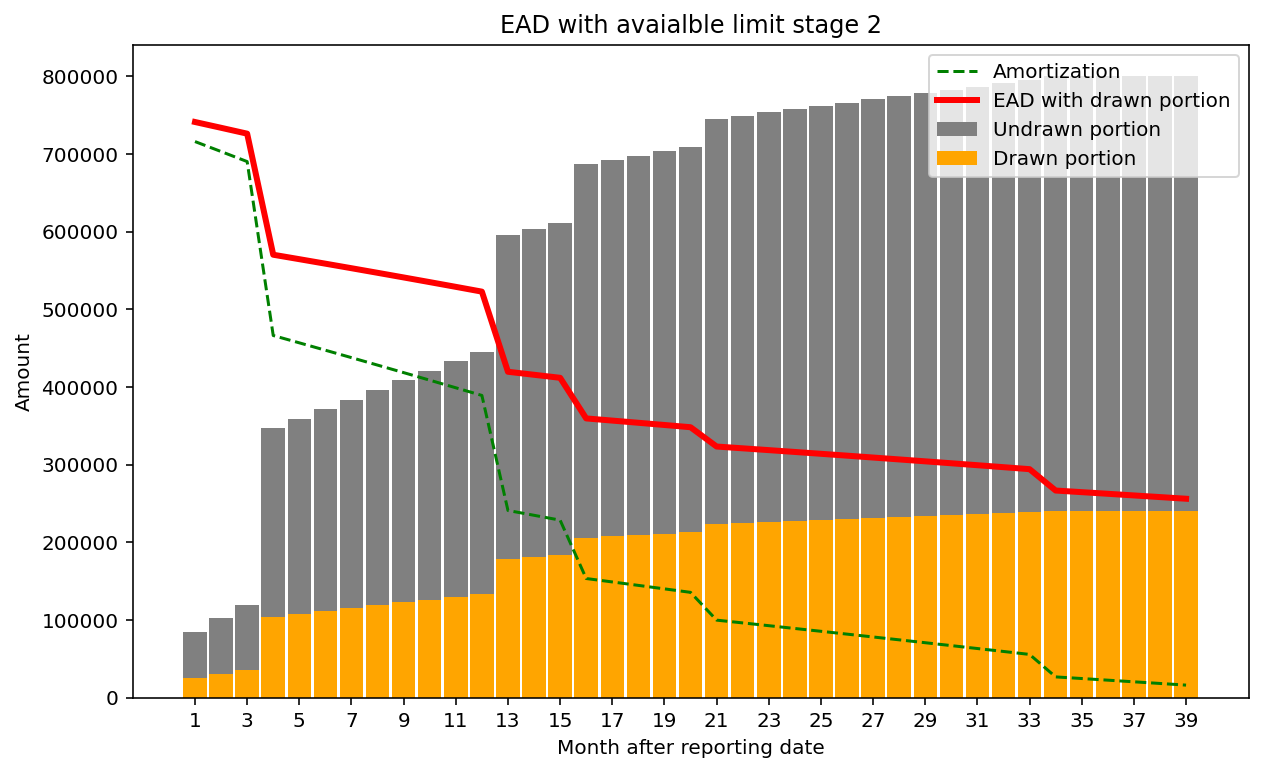

In [37]:
# Plot
plotEAD(dataPlot, 2, 0.3)

In [38]:
# Stage 3
dataPlot = ECL.query("LimitID == '999999999999948'")
dataPlot

,AsOfDate,LimitID,Limit,Stage,DiscountTime,Outstanding,Installment,EIR,AvailableLimit
12,2022-12-31,999999999999948,441614.95,3,1,263202.28,17307.48,6.76,178412.67


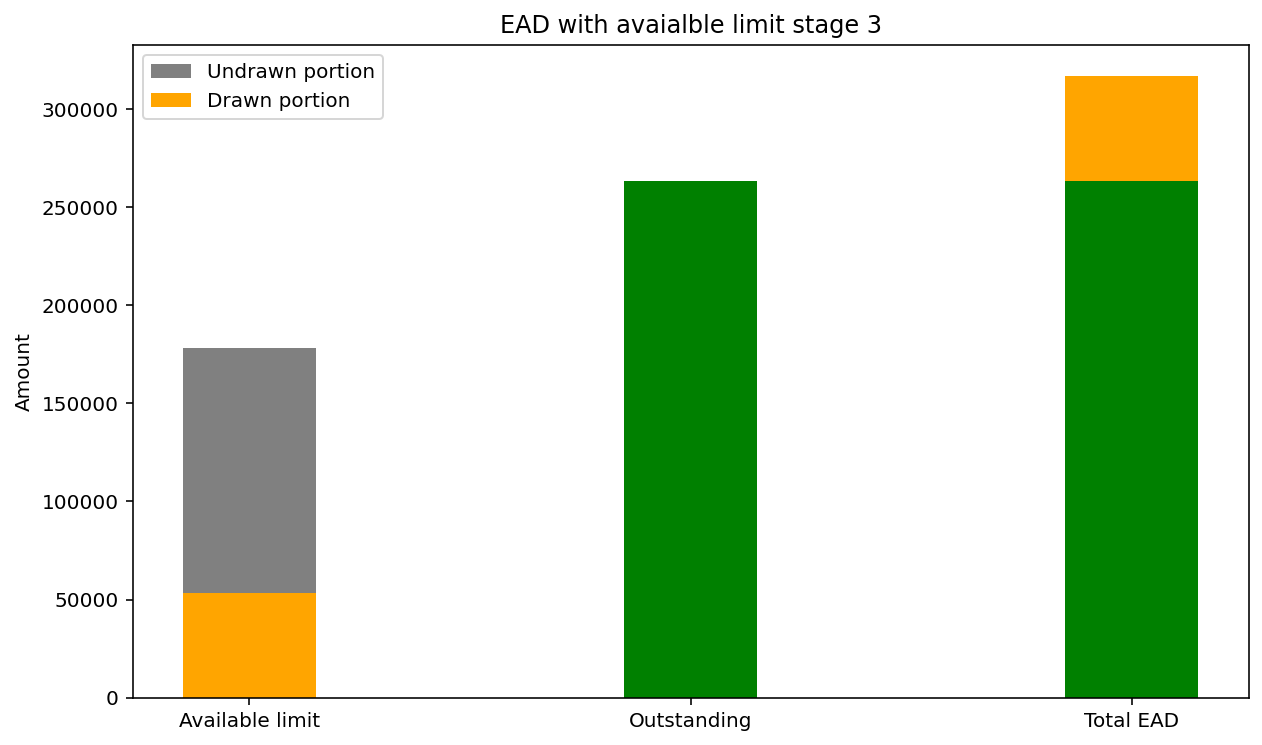

In [39]:
# Plot
plt.figure(figsize = (10, 6))
plotRange = ['Available limit', 'Outstanding', 'Total EAD']
plt.bar(
    plotRange[0],
    dataPlot['AvailableLimit'],
    color = 'gray',
    width = 0.3,
    label = 'Undrawn portion'
)
plt.bar(
    plotRange[0],
    dataPlot['AvailableLimit'] * 0.3,
    color = 'orange',
    width = 0.3,
    label = 'Drawn portion'
)
plt.bar(
    plotRange[1],
    dataPlot['Outstanding'],
    color = 'green',
    width = 0.3
)
plt.bar(
    plotRange[2],
    dataPlot['Outstanding'] + dataPlot['AvailableLimit'] * 0.3,
    color = 'orange',
    width = 0.3
)
plt.bar(
    plotRange[2],
    dataPlot['Outstanding'],
    color = 'green',
    width = 0.3
)
plt.title('EAD with avaialble limit stage 3')
plt.ylabel('Amount')
plt.legend(frameon = True, facecolor = 'white', loc = 0)
plt.show()